# Plot 0.05-degree data in North America for a given month


In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from cmcrameri import cm
import plot

In [3]:
year = 2020
month = 7
offset = 1
month_xco2 = month + offset

In [4]:
res = 0.05
extents = {"lon0_b": -125, "lon1_b": -65, "lat0_b": 22, "lat1_b": 58}
ds_grid = xe.util.cf_grid_2d(**extents, d_lon=res, d_lat=res)
df_grid = ds_grid.to_dataframe().reset_index()
df_grid


,lon,bound,lat,lon_bounds,lat_bounds,latitude_longitude
0,-124.975,0,22.025,-125.0,22.00,NaN
1,-124.975,0,22.075,-125.0,22.05,NaN
2,-124.975,0,22.125,-125.0,22.10,NaN
3,-124.975,0,22.175,-125.0,22.15,NaN
4,-124.975,0,22.225,-125.0,22.20,NaN
...,...,...,...,...,...,...
1727995,-65.025,1,57.775,-65.0,57.80,NaN
1727996,-65.025,1,57.825,-65.0,57.85,NaN
1727997,-65.025,1,57.875,-65.0,57.90,NaN
1727998,-65.025,1,57.925,-65.0,57.95,NaN


In [5]:
ds_grid

<xarray.Dataset>
Dimensions:             (lon: 1200, bound: 2, lat: 720)
Coordinates:
  * lon                 (lon) float64 -125.0 -124.9 -124.9 ... -65.08 -65.03
  * lat                 (lat) float64 22.02 22.08 22.12 ... 57.88 57.93 57.98
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (bound, lon) float64 -125.0 -125.0 ... -65.05 -65.0
    lat_bounds          (bound, lat) float64 22.0 22.05 22.1 ... 57.9 57.95 58.0

## SIF

In [6]:
with xr.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc") as ds:
    ds = ds.where(ds.time.dt.year == year, drop=True)
    ds = ds.where(ds.time.dt.month == month, drop=True)
    bounds = (
        (ds.lon >= extents["lon0_b"])
        & (ds.lon <= extents["lon1_b"])
        & (ds.lat >= extents["lat0_b"])
        & (ds.lat <= extents["lat1_b"])
    )
    ds_sif = ds.where(bounds, drop=True)
    m_start = np.datetime_as_string(ds_sif.time.min(), unit="D")
    m_end = np.datetime_as_string(ds_sif.time.max(), unit="D")
    df_sif = ds_sif.to_dataframe().reset_index()

df_sif.to_csv(f"OCO2_Lite_SIF740_north_america_{year}0{month}.csv")

# df_sif = pd.read_csv(f"OCO2_Lite_SIF740_north_america_{year}0{month}.csv")

df_sif = df_sif[["sif", "lon", "lat"]]
df_sif

,sif,lon,lat
0,0.256351,-74.772583,39.465942
1,1.516239,-74.778931,39.484314
2,0.638593,-74.774414,39.474609
3,0.902742,-74.769958,39.464783
4,0.957302,-74.785339,39.502747
...,...,...,...
410272,0.287434,-107.071289,57.986023
410273,0.548618,-107.184937,57.997192
410274,0.244807,-107.215393,57.990784
410275,-0.130486,-107.246216,57.984924


In [7]:
# overwrite lon-lat values with grid values
lon_bounds = np.append(ds_grid.lon_bounds.values[0, :], ds_grid.lon_bounds.values[1, -1])
lat_bounds = np.append(ds_grid.lat_bounds.values[0, :], ds_grid.lat_bounds.values[1, -1])
df_sif["lon"] = pd.cut(df_sif.lon, lon_bounds, labels=ds_grid.lon.values).astype(float)
df_sif["lat"] = pd.cut(df_sif.lat, lat_bounds, labels=ds_grid.lat.values).astype(float)

ds_sif = df_sif.groupby(["lon", "lat"]).mean().to_xarray()
ds_sif

<xarray.Dataset>
Dimensions:  (lon: 1200, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    sif      (lon, lat) float32 nan nan nan nan nan nan ... nan nan nan nan nan

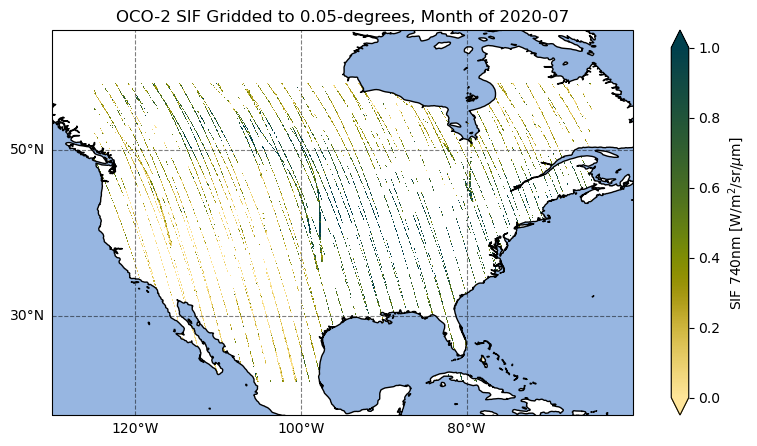

In [8]:
title = f"OCO-2 SIF Gridded to {res}-degrees, Month of {year}-0{month}"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(ds_sif["sif"], vmin=0, vmax=1, title=title, label=units)

In [9]:
ds_sif.to_netcdf(f"0{str(res).split('.')[-1]}_deg_gridded_sif_{year}0{month}.nc")

## XCO2

In [10]:
with xr.open_dataset("../data/exp_pro/OCO2_Lite_XCO2.nc") as ds:
    ds = ds.where(ds.time.dt.year == year, drop=True)
    ds = ds.where(ds.time.dt.month == month_xco2, drop=True)
    bounds = (
        (ds.lon >= extents["lon0_b"])
        & (ds.lon <= extents["lon1_b"])
        & (ds.lat >= extents["lat0_b"])
        & (ds.lat <= extents["lat1_b"])
    )
    ds_xco2 = ds.where(bounds, drop=True)
    m_start = np.datetime_as_string(ds_xco2.time.min(), unit="D")
    m_end = np.datetime_as_string(ds_xco2.time.max(), unit="D")
    df_xco2 = ds_xco2.to_dataframe().reset_index()

df_xco2.to_csv(f"OCO2_Lite_XCO2_north_america_{year}0{month_xco2}.csv")

# df_xco2 = pd.read_csv(f"OCO2_Lite_XCO2_north_america_{year}0{month_xco2}.csv")

df_xco2 = df_xco2[["xco2", "lon", "lat"]]
df_xco2

,xco2,lon,lat
0,405.235168,-65.001122,47.764992
1,407.567566,-65.003189,47.834122
2,406.199341,-65.542557,49.097046
3,404.687531,-65.532394,49.089745
4,407.360107,-65.522339,49.082310
...,...,...,...
180686,408.867188,-120.013901,46.318302
180687,408.333740,-120.011292,46.326683
180688,409.699524,-120.000496,46.316971
180689,408.331329,-119.998550,46.324848


In [11]:
# overwrite lon-lat values with grid values
lon_bounds = np.append(ds_grid.lon_bounds.values[0, :], ds_grid.lon_bounds.values[1, -1])
lat_bounds = np.append(ds_grid.lat_bounds.values[0, :], ds_grid.lat_bounds.values[1, -1])
df_xco2["lon"] = pd.cut(df_xco2.lon, lon_bounds, labels=ds_grid.lon.values).astype(float)
df_xco2["lat"] = pd.cut(df_xco2.lat, lat_bounds, labels=ds_grid.lat.values).astype(float)

ds_xco2 = df_xco2.groupby(["lon", "lat"]).mean().to_xarray()
ds_xco2

<xarray.Dataset>
Dimensions:  (lon: 1171, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    xco2     (lon, lat) float32 nan nan nan nan nan nan ... nan nan nan nan nan

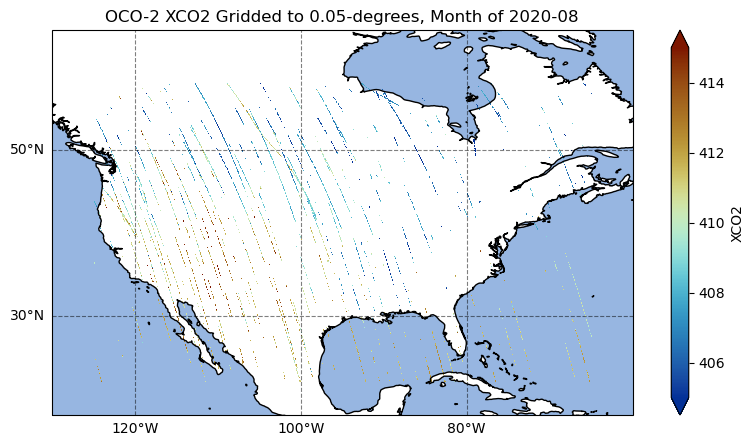

In [12]:
title = f"OCO-2 XCO2 Gridded to {res}-degrees, Month of {year}-0{month_xco2}"
units = "XCO2"
plot.plot_da(ds_xco2["xco2"], vmin=405, vmax=415, cmap=cm.roma_r, title=title, label=units)

In [13]:
ds_xco2.to_netcdf(f"0{str(res).split('.')[-1]}_deg_gridded_xco2_{year}0{month_xco2}.nc")